In [4]:
#Libraries
from matplotlib import pyplot
from numpy import savez_compressed, asarray, load
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import load
from numpy import expand_dims
import numpy as np
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image
import joblib

# Load models
path_to_model = "../models/facenet_keras.h5"
model = load_model(path_to_model) #facenet
svc_model = joblib.load('svc.sav') #SVC

In [9]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
	# show the plot
	pyplot.show()
 

In [10]:
# load image from file
#filename = 'Inferencias/elton_oscar.jpg'
filename = "elton_john_asdf.jpg"
pixels = pyplot.imread(filename)

# create the detector, using default weights
detector = MTCNN()

# detect faces in the image

faces = detector.detect_faces(pixels)
# Extract faces in image
picture = extract_face(filename, required_size=(160, 160))
savez_compressed('picture.npz', picture)

# convert each face in the train set to an embedding
newTrainX = list()
embedding = get_embedding(model, picture)
newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# save arrays to one file in compressed format
savez_compressed('picture-embeddings.npz', newTrainX)

(1, 128)


Madonna
2


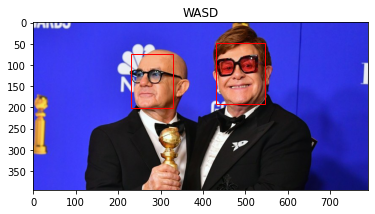

In [13]:
# prediction for the face
yhat_class = svc_model.predict(newTrainX)
yhat_prob = svc_model.predict_proba(newTrainX)

#Label names
labels = ("Ben Affleck", "Elton John", "Madonna", "Jerry Seinfield", "Mindy Kaling")
title = "WASD"

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100

for i in range(len(labels)):
    if class_index == i:
        print(labels[i])
print(class_index)        
# plot for fun
pyplot.title(title)
draw_image_with_boxes(filename, faces)
title = (class_probability)

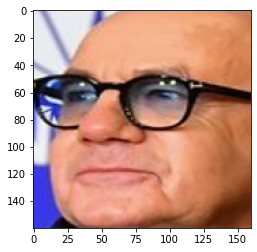

In [14]:
pyplot.imshow(picture)